
ENHANCED MODEL TRAINING PIPELINE - 7 MODELS

✓ Loaded data: 46421 rows, 57 columns
✓ Filtered dataset size: 46405
✓ Kept 12 classes with >= 30 samples
✓ Found 52 keypoint columns

--- Feature Engineering ---
✓ Encoded labels: 12 classes

--- Data Cleaning ---
✓ Train/test split: 37124/9281 samples

TRAINING 7 MODELS

[1/7] Training Random Forest...
✓ Random Forest trained

[2/7] Training Extra Trees...
✓ Extra Trees trained

[3/7] Training XGBoost...
✓ XGBoost trained

[4/7] Training LightGBM...
✓ LightGBM trained

[5/7] Training HistGradientBoosting...
✓ HistGradientBoosting trained

[6/7] Training Gradient Boosting...
✓ Gradient Boosting trained

[7/7] Training SGD Classifier...
✓ SGD Classifier trained

EVALUATING ALL MODELS

--- Evaluating Random Forest ---
Test - F1: 0.8202, Precision: 0.8246, Recall: 0.8196, ROC-AUC: 0.9831

--- Evaluating Extra Trees ---
Test - F1: 0.6658, Precision: 0.7344, Recall: 0.6318, ROC-AUC: 0.9572

--- Evaluating XGBoost ---
Test - F1: 0.8046, Precisio

INFO: ✓ Saved: comprehensive_model_comparison.png


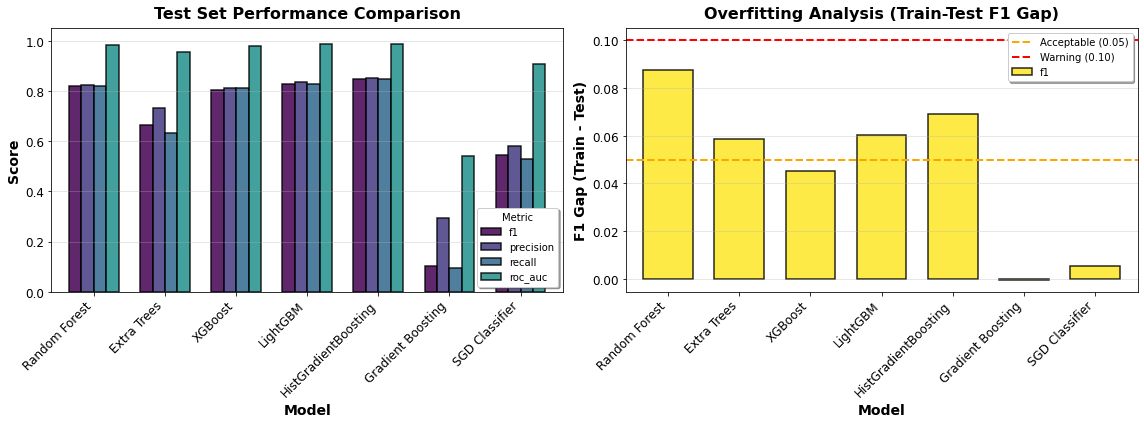


COMPREHENSIVE MODEL COMPARISON
Model                   Test F1   Train F1        Gap   Test AUC Status         
------------------------------------------------------------------------------------------
Random Forest            0.8202     0.9078     0.0875     0.9831 ✓ Good         
Extra Trees              0.6658     0.7246     0.0588     0.9572 ✓ Good         
XGBoost                  0.8046     0.8498     0.0452     0.9791 ✓ Excellent    
LightGBM                 0.8294     0.8897     0.0603     0.9866 ✓ Good         
HistGradientBoosting     0.8465     0.9157     0.0692     0.9877 ✓ Good         
Gradient Boosting        0.1030     0.1026    -0.0004     0.5424 ✓ Excellent    
SGD Classifier           0.5468     0.5521     0.0053     0.9070 ✓ Excellent    


BEST MODEL: HistGradientBoosting
Test F1 Score: 0.8465
✓ Saved best model: best_model_histgradientboosting.joblib
✓ Saved metrics: model_metrics.json

✓ Training complete!
✓ Best model: HistGradientBoosting
✓ Final F1 Score: 0.

In [1]:
"""
Enhanced Feature Selection and Model Training Pipeline
======================================
ENHANCEMENTS:
1. Added LightGBM (very fast gradient boosting)
2. Added HistGradientBoosting (sklearn's native fast gradient boosting)
3. Added Extra Trees Classifier (faster than Random Forest)
4. Added Gradient Boosting Classifier (scikit-learn implementation)
5. Added SGD Classifier (very fast linear model for large datasets)
6. All models optimized for CPU performance
7. Comprehensive model comparison with visualization
"""
import os
import numpy as np
import pandas as pd
import pickle
import json
from pathlib import Path
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, 
                              GradientBoostingClassifier, HistGradientBoostingClassifier)
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from tabpfn import TabPFNClassifier
import joblib  
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold

# NEW IMPORTS
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# =============================================================================
# HELPER FUNCTIONS 
# =============================================================================

def add_derived_pose_features(df):
    """
    Add comprehensive joint angles, distances, and symmetry features.
    """
    
    def compute_angle(a, b, c):
        """Compute angle at point b formed by points a-b-c"""
        ba = a - b
        bc = c - b
        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc) + 1e-8)
        return np.arccos(np.clip(cosine_angle, -1.0, 1.0)) * (180.0 / np.pi)

    def compute_distance(p1, p2):
        """Euclidean distance between two points"""
        return np.linalg.norm(p1 - p2)

    # === JOINT ANGLES ===
    df['r_elbow_angle'] = df.apply(lambda row: compute_angle(
        np.array([row['r_shoulder_x'], row['r_shoulder_y']]),
        np.array([row['r_elbow_x'], row['r_elbow_y']]),
        np.array([row['r_wrist_x'], row['r_wrist_y']])
    ), axis=1)

    df['l_elbow_angle'] = df.apply(lambda row: compute_angle(
        np.array([row['l_shoulder_x'], row['l_shoulder_y']]),
        np.array([row['l_elbow_x'], row['l_elbow_y']]),
        np.array([row['l_wrist_x'], row['l_wrist_y']])
    ), axis=1)

    df['r_shoulder_angle'] = df.apply(lambda row: compute_angle(
        np.array([row['neck_x'], row['neck_y']]),
        np.array([row['r_shoulder_x'], row['r_shoulder_y']]),
        np.array([row['r_elbow_x'], row['r_elbow_y']])
    ), axis=1)

    df['l_shoulder_angle'] = df.apply(lambda row: compute_angle(
        np.array([row['neck_x'], row['neck_y']]),
        np.array([row['l_shoulder_x'], row['l_shoulder_y']]),
        np.array([row['l_elbow_x'], row['l_elbow_y']])
    ), axis=1)

    df['r_knee_angle'] = df.apply(lambda row: compute_angle(
        np.array([row['r_hip_x'], row['r_hip_y']]),
        np.array([row['r_knee_x'], row['r_knee_y']]),
        np.array([row['r_ankle_x'], row['r_ankle_y']])
    ), axis=1)

    df['l_knee_angle'] = df.apply(lambda row: compute_angle(
        np.array([row['l_hip_x'], row['l_hip_y']]),
        np.array([row['l_knee_x'], row['l_knee_y']]),
        np.array([row['l_ankle_x'], row['l_ankle_y']])
    ), axis=1)

    df['r_hip_angle'] = df.apply(lambda row: compute_angle(
        np.array([row['mid_hip_x'], row['mid_hip_y']]),
        np.array([row['r_hip_x'], row['r_hip_y']]),
        np.array([row['r_knee_x'], row['r_knee_y']])
    ), axis=1)

    df['l_hip_angle'] = df.apply(lambda row: compute_angle(
        np.array([row['mid_hip_x'], row['mid_hip_y']]),
        np.array([row['l_hip_x'], row['l_hip_y']]),
        np.array([row['l_knee_x'], row['l_knee_y']])
    ), axis=1)

    df['trunk_angle'] = df.apply(lambda row: compute_angle(
        np.array([row['nose_x'], row['nose_y']]),
        np.array([row['neck_x'], row['neck_y']]),
        np.array([row['mid_hip_x'], row['mid_hip_y']])
    ), axis=1)

    # === DISTANCES ===
    df['eye_to_eye'] = df.apply(lambda row: compute_distance(
        np.array([row['l_eye_x'], row['l_eye_y']]),
        np.array([row['r_eye_x'], row['r_eye_y']])
    ), axis=1)

    df['nose_to_neck'] = df.apply(lambda row: compute_distance(
        np.array([row['nose_x'], row['nose_y']]),
        np.array([row['neck_x'], row['neck_y']])
    ), axis=1)

    df['r_wrist_to_hip'] = df.apply(lambda row: compute_distance(
        np.array([row['r_wrist_x'], row['r_wrist_y']]),
        np.array([row['mid_hip_x'], row['mid_hip_y']])
    ), axis=1)

    df['l_wrist_to_hip'] = df.apply(lambda row: compute_distance(
        np.array([row['l_wrist_x'], row['l_wrist_y']]),
        np.array([row['mid_hip_x'], row['mid_hip_y']])
    ), axis=1)

    df['r_wrist_to_nose'] = df.apply(lambda row: compute_distance(
        np.array([row['r_wrist_x'], row['r_wrist_y']]),
        np.array([row['nose_x'], row['nose_y']])
    ), axis=1)

    df['l_wrist_to_nose'] = df.apply(lambda row: compute_distance(
        np.array([row['l_wrist_x'], row['l_wrist_y']]),
        np.array([row['nose_x'], row['nose_y']])
    ), axis=1)

    df['nose_to_ankles'] = df.apply(lambda row: (
        compute_distance(np.array([row['nose_x'], row['nose_y']]),
                         np.array([row['l_ankle_x'], row['l_ankle_y']])) +
        compute_distance(np.array([row['nose_x'], row['nose_y']]),
                         np.array([row['r_ankle_x'], row['r_ankle_y']]))
    ) / 2, axis=1)

    df['hip_to_ankle'] = df.apply(lambda row: (
        compute_distance(np.array([row['mid_hip_x'], row['mid_hip_y']]),
                         np.array([row['l_ankle_x'], row['l_ankle_y']])) +
        compute_distance(np.array([row['mid_hip_x'], row['mid_hip_y']]),
                         np.array([row['r_ankle_x'], row['r_ankle_y']]))
    ) / 2, axis=1)

    # === SYMMETRY FEATURES ===
    df['shoulder_y_diff'] = df['l_shoulder_y'] - df['r_shoulder_y']
    df['hip_y_diff'] = df['l_hip_y'] - df['r_hip_y']
    df['elbow_angle_diff'] = df['l_elbow_angle'] - df['r_elbow_angle']
    df['knee_angle_diff'] = df['l_knee_angle'] - df['r_knee_angle']
    df['wrist_to_hip_diff'] = df['l_wrist_to_hip'] - df['r_wrist_to_hip']
    df['shoulder_angle_diff'] = df['l_shoulder_angle'] - df['r_shoulder_angle']

    df['com_x'] = (df['mid_hip_x'] + df['neck_x']) / 2
    df['com_y'] = (df['mid_hip_y'] + df['neck_y']) / 2
    
    df['body_spread_x'] = df[['l_wrist_x', 'r_wrist_x', 'l_ankle_x', 'r_ankle_x']].max(axis=1) - \
                          df[['l_wrist_x', 'r_wrist_x', 'l_ankle_x', 'r_ankle_x']].min(axis=1)
    df['body_spread_y'] = df[['nose_y', 'l_ankle_y', 'r_ankle_y']].max(axis=1) - \
                          df[['nose_y', 'l_ankle_y', 'r_ankle_y']].min(axis=1)

    return df


def add_temporal_features(df, keypoints, fps=15, window_sizes=[3, 5, 7]):
    """Add temporal features with improved handling of infinite values"""
    df = df.sort_values(by=['annotation_label', 'time_s'])
    
    df['delta_time'] = df.groupby('annotation_label')['time_s'].diff().fillna(1/fps)
    df['delta_time'] = df['delta_time'].replace(0, np.nan)
    df['delta_time'] = df['delta_time'].fillna(1/fps)
    df['delta_time'] = df['delta_time'].clip(lower=0.0001)
    
    velocities = {}
    accelerations = {}
    
    selected_keypoints = [
        'com_x', 'com_y', 'nose_x', 'nose_y',
        'l_wrist_x', 'l_wrist_y', 'r_wrist_x', 'r_wrist_y'
    ]
    
    for col in selected_keypoints:
        if col not in df.columns:
            continue
            
        vel_col = f'{col}_vel'
        velocities[vel_col] = df.groupby('annotation_label')[col].diff() / df['delta_time']
        
        acc_col = f'{col}_acc'
        accelerations[acc_col] = velocities[vel_col].groupby(df['annotation_label']).diff() / df['delta_time']
    
    velocity_df = pd.DataFrame(velocities)
    acceleration_df = pd.DataFrame(accelerations)
    
    velocity_df = velocity_df.replace([np.inf, -np.inf], np.nan)
    acceleration_df = acceleration_df.replace([np.inf, -np.inf], np.nan)
    
    df = pd.concat([df, velocity_df, acceleration_df], axis=1)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
    
    velocity_cols = list(velocity_df.columns)
    acceleration_cols = list(acceleration_df.columns)
    df[velocity_cols + acceleration_cols] = df[velocity_cols + acceleration_cols].fillna(0)
    
    derived_features = [
        col for col in df.columns 
        if col not in keypoints 
        and col not in velocity_cols 
        and col not in acceleration_cols
        and not col.startswith(('annotation_label', 'frame', 'time', 'person_label', 'delta_time'))
    ]
    
    features = velocity_cols + acceleration_cols + derived_features
    
    return df, features


def normalize_keypoints(df, keypoints):
    """Normalize keypoints relative to torso length"""
    df['torso_length'] = np.sqrt(
        (df['neck_x'] - df['mid_hip_x'])**2 + 
        (df['neck_y'] - df['mid_hip_y'])**2
    )
    
    df['torso_length'] = df['torso_length'].replace(0, np.nan)
    df['torso_length'] = df['torso_length'].fillna(df['torso_length'].median())
    df['torso_length'] = df['torso_length'].clip(lower=1e-3)

    for col in keypoints:
        if '_x' in col:
            df[col] = (df[col] - df['mid_hip_x']) / df['torso_length']
        else:
            df[col] = (df[col] - df['mid_hip_y']) / df['torso_length']

    return df


def simplify_feature_selection(df, non_coordinate_cols, pca_components=50):
    """Simplified feature selection with PCA"""
    coordinate_cols = ['neck_x', 'neck_y', 'r_wrist_x', 'r_wrist_y','l_wrist_x', 'l_wrist_y',  
                        'r_hip_x', 'r_hip_y', 'r_knee_x', 'r_knee_y', 'r_ankle_x', 'r_ankle_y', 
                        'l_hip_x', 'l_hip_y', 'l_knee_x', 'l_knee_y', 'l_ankle_x', 'l_ankle_y', 
                        'r_eye_x', 'r_eye_y', 'l_eye_x', 'l_eye_y', 'r_ear_x', 'r_ear_y', 
                        'l_ear_x', 'l_ear_y', 'l_big_toe_x', 'l_big_toe_y', 'l_small_toe_x', 
                        'l_small_toe_y', 'l_heel_x', 'l_heel_y', 'r_big_toe_x', 'r_big_toe_y', 
                        'r_small_toe_x', 'r_small_toe_y', 'r_heel_x', 'r_heel_y', 'background_x', 
                        'background_y']
    
    coordinate_cols_to_drop = [col for col in coordinate_cols if col in df.columns]
    df = df.drop(columns=coordinate_cols_to_drop)
    
    feature_cols = [col for col in df.columns if col not in non_coordinate_cols]
    numeric_feature_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
    
    X = df[numeric_feature_cols].values
    
    inf_count = np.isinf(X).sum()
    if inf_count > 0:
        X = np.where(np.isinf(X), np.nan, X)
    
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    
    pca = PCA(n_components=pca_components)
    X_pca = pca.fit_transform(X_imputed)
    
    selected_features_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(pca_components)])
    
    return X_pca, selected_features_df, pca


def calculate_training_metrics(model, X_train, y_train, model_name="Model"):
    """Calculate training set performance metrics"""
    print(f"\n--- Training Set Performance: {model_name} ---")
    
    y_train_pred = model.predict(X_train)
    y_train_pred_prob = model.predict_proba(X_train)
    
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    train_roc_auc = roc_auc_score(y_train, y_train_pred_prob, multi_class='ovr', average='macro')
    
    print(f"Training F1: {train_f1:.4f}, Precision: {train_precision:.4f}, "
          f"Recall: {train_recall:.4f}, ROC-AUC: {train_roc_auc:.4f}")
    
    return {
        'f1': train_f1,
        'precision': train_precision,
        'recall': train_recall,
        'roc_auc': train_roc_auc
    }


def plot_comprehensive_model_comparison(test_metrics_dict, train_metrics_dict, save_dir=None):
    """
    Create comprehensive comparison plot for all models
    """
    TITLE_SIZE = 16
    LABEL_SIZE = 14
    TICK_SIZE = 12
    LEGEND_SIZE = 10
    
    # Convert to DataFrame for easier plotting
    test_df = pd.DataFrame(test_metrics_dict).T
    train_df = pd.DataFrame(train_metrics_dict).T
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Define color palette (viridis-based)
    colors = plt.cm.viridis(np.linspace(0, 1, len(test_df)))
    
    # Test metrics
    test_df.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black', 
                linewidth=1.5, alpha=0.85, width=0.7)
    axes[0].set_title('Test Set Performance Comparison', fontsize=TITLE_SIZE, weight='bold', pad=10)
    axes[0].set_ylabel('Score', fontsize=LABEL_SIZE, weight='bold')
    axes[0].set_xlabel('Model', fontsize=LABEL_SIZE, weight='bold')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right', fontsize=TICK_SIZE)
    axes[0].tick_params(axis='y', labelsize=TICK_SIZE)
    axes[0].legend(title='Metric', fontsize=LEGEND_SIZE, title_fontsize=LEGEND_SIZE, 
                  frameon=True, shadow=True, loc='lower right')
    axes[0].grid(True, alpha=0.3, axis='y', linewidth=1)
    axes[0].set_ylim([0, 1.05])
    
    # Overfitting analysis (Train - Test gap)
    gap_df = train_df - test_df
    gap_df['f1'].plot(kind='bar', ax=axes[1], color='#fde725', edgecolor='black',
                     linewidth=1.5, alpha=0.85, width=0.7)
    axes[1].axhline(y=0.05, color='orange', linestyle='--', linewidth=2, label='Acceptable (0.05)')
    axes[1].axhline(y=0.10, color='red', linestyle='--', linewidth=2, label='Warning (0.10)')
    axes[1].set_title('Overfitting Analysis (Train-Test F1 Gap)', fontsize=TITLE_SIZE, weight='bold', pad=10)
    axes[1].set_ylabel('F1 Gap (Train - Test)', fontsize=LABEL_SIZE, weight='bold')
    axes[1].set_xlabel('Model', fontsize=LABEL_SIZE, weight='bold')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right', fontsize=TICK_SIZE)
    axes[1].tick_params(axis='y', labelsize=TICK_SIZE)
    axes[1].legend(fontsize=LEGEND_SIZE, frameon=True, shadow=True)
    axes[1].grid(True, alpha=0.3, axis='y', linewidth=1)
    
    plt.tight_layout()
    
    if save_dir:
        plt.savefig(Path(save_dir) / 'comprehensive_model_comparison.png', dpi=150, bbox_inches='tight')
        logger.info(f"✓ Saved: comprehensive_model_comparison.png")
    
    plt.show()
    plt.close(fig)
    
    # Print detailed comparison
    print(f"\n{'='*90}")
    print("COMPREHENSIVE MODEL COMPARISON")
    print(f"{'='*90}")
    print(f"{'Model':<20} {'Test F1':>10} {'Train F1':>10} {'Gap':>10} {'Test AUC':>10} {'Overfitting Status':<15}")
    print(f"{'-'*90}")
    
    for model_name in test_df.index:
        test_f1 = test_metrics_dict[model_name]['f1']
        train_f1 = train_metrics_dict[model_name]['f1']
        gap = train_f1 - test_f1
        test_auc = test_metrics_dict[model_name]['roc_auc']
        
        if gap < 0.05:
            status = "✓ Excellent"
        elif gap < 0.10:
            status = "✓ Good"
        elif gap < 0.15:
            status = "⚠ Moderate"
        else:
            status = "✗ High overfit"
        
        print(f"{model_name:<20} {test_f1:>10.4f} {train_f1:>10.4f} {gap:>10.4f} {test_auc:>10.4f} {status:<15}")
    
    print(f"{'='*90}\n")


# =============================================================================
# MAIN PIPELINE WITH ADDITIONAL MODELS
# =============================================================================

def main(results, output_dir=None):
    """
    Enhanced training pipeline different models:
    1. Random Forest
    2. Extra Trees (faster variant of RF)
    3. XGBoost
    4. LightGBM (fastest gradient boosting)
    5. HistGradientBoosting (sklearn native)
    6. Gradient Boosting (sklearn classic)
    7. SGD Classifier (very fast linear model)
    """
    
    print("\n" + "="*70)
    print("ENHANCED MODEL TRAINING PIPELINE - 7 MODELS")
    print("="*70)
    
    # Load and prepare data (keeping your existing preprocessing)
    df = results['labeled_features'].copy()
    print(f"\n✓ Loaded data: {df.shape[0]} rows, {df.shape[1]} columns")
    
    label_to_class_map = {
        'CS': 'vocalizations', 'CNS': 'vocalizations', 'TS': 'vocalizations', 'TNS': 'vocalizations',
        'CGO': 'unlabeled', 'TGO': 'unlabeled',
        'TC': 'joint_attention', 'AO': 'joint_attention', 'AT': 'joint_attention',
        'GO': 'joint_attention', 'GT': 'joint_attention',
        'T': 'interactions', 'T_V': 'interactions', 'T_P': 'interactions', 'C': 'interactions',
        'TST': 'coordination', 'THO': 'coordination', 'TSI': 'coordination', 'TLF': 'coordination',
        'TRE': 'coordination', 'TCR': 'coordination', 'CST': 'coordination', 'CHO': 'coordination',
        'CSI': 'coordination', 'CLF': 'coordination', 'CRE': 'coordination', 'CCR': 'coordination'
    }

    df['label_class'] = df['annotation_label'].map(label_to_class_map)
    non_posture_classes = ['vocalizations', 'unlabeled']
    df = df[~df['label_class'].isin(non_posture_classes)]

    print(f"✓ Filtered dataset size: {df.shape[0]}")
    
    min_samples = 30
    class_counts = df['annotation_label'].value_counts()
    valid_classes = class_counts[class_counts >= min_samples].index.tolist()
    df = df[df['annotation_label'].isin(valid_classes)]
    print(f"✓ Kept {len(valid_classes)} classes with >= {min_samples} samples")

    keypoints = [col for col in df.columns if '_x' in col or '_y' in col]
    print(f"✓ Found {len(keypoints)} keypoint columns")
    
    # Feature engineering
    print("\n--- Feature Engineering ---")
    df = normalize_keypoints(df, keypoints)
    df = add_derived_pose_features(df)
    df, temporal_features = add_temporal_features(df, keypoints, window_sizes=[3, 5])

    # Label encoding
    label_encoder = LabelEncoder()
    df['label_encoded'] = label_encoder.fit_transform(df['annotation_label'])
    print(f"✓ Encoded labels: {len(label_encoder.classes_)} classes")
    
    # Data cleaning
    print("\n--- Data Cleaning ---")
    target_labels = df['annotation_label'].copy()
    columns_to_drop = ['time_s', 'avg_pose_conf', 'annotation_label']
    existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
    df.drop(columns=existing_columns_to_drop, inplace=True)
    
    if 'person_label' in df.columns:
        df = pd.get_dummies(df, columns=['person_label'], prefix='person')
    
    non_numeric_cols = df.select_dtypes(include=['object']).columns.tolist()
    if non_numeric_cols:
        df.drop(columns=non_numeric_cols, inplace=True)
    
    # Apply PCA
    non_coordinate_cols = ['label_encoded', 'frame', 'delta_time']
    X_pca, selected_features_df, pca_model = simplify_feature_selection(df, non_coordinate_cols)
    
    if output_dir:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        X_pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
        X_pca_df.to_parquet(output_dir / "X_pca.parquet", index=False)
        selected_features_df.to_parquet(output_dir / "selected_features_df.parquet", index=False)
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_pca, df['label_encoded'], 
        test_size=0.2, stratify=df['label_encoded'], 
        random_state=42
    )
    print(f"✓ Train/test split: {len(X_train)}/{len(X_test)} samples")
    
    # Cross-validation setup
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    # =============================================================================
    # MODEL TRAINING - 7 MODELS
    # =============================================================================
    
    models_dict = {}
    train_metrics_dict = {}
    test_metrics_dict = {}
    
    print("\n" + "="*70)
    print("TRAINING 7 MODELS")
    print("="*70)
    
    # -------------------------------------------------------------------
    # 1. RANDOM FOREST
    # -------------------------------------------------------------------
    print("\n[1/7] Training Random Forest...")
    rf_model = RandomForestClassifier(
        n_estimators=150,
        max_depth=12,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    models_dict['Random Forest'] = rf_model
    print("✓ Random Forest trained")
    
    # -------------------------------------------------------------------
    # 2. EXTRA TREES (Faster than Random Forest)
    # -------------------------------------------------------------------
    print("\n[2/7] Training Extra Trees...")
    et_model = ExtraTreesClassifier(
        n_estimators=150,
        max_depth=12,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    et_model.fit(X_train, y_train)
    models_dict['Extra Trees'] = et_model
    print("✓ Extra Trees trained")
    
    # -------------------------------------------------------------------
    # 3. XGBOOST
    # -------------------------------------------------------------------
    print("\n[3/7] Training XGBoost...")
    xgb_model = XGBClassifier(
        n_estimators=150,
        max_depth=4,
        learning_rate=0.08,
        subsample=0.7,
        colsample_bytree=0.7,
        min_child_weight=5,
        gamma=0.2,
        reg_alpha=1.0,
        reg_lambda=3,
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    xgb_model.fit(X_train, y_train)
    models_dict['XGBoost'] = xgb_model
    print("✓ XGBoost trained")
    
    # -------------------------------------------------------------------
    # 4. LIGHTGBM (Very fast gradient boosting)
    # -------------------------------------------------------------------
    print("\n[4/7] Training LightGBM...")
    lgb_model = lgb.LGBMClassifier(
        n_estimators=150,
        max_depth=4,
        learning_rate=0.08,
        num_leaves=31,
        subsample=0.7,
        colsample_bytree=0.7,
        min_child_samples=20,
        reg_alpha=1.0,
        reg_lambda=3,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgb_model.fit(X_train, y_train)
    models_dict['LightGBM'] = lgb_model
    print("✓ LightGBM trained")
    
    # -------------------------------------------------------------------
    # 5. HISTGRADIENTBOOSTING (sklearn's fast native gradient boosting)
    # -------------------------------------------------------------------
    print("\n[5/7] Training HistGradientBoosting...")
    hist_model = HistGradientBoostingClassifier(
        max_iter=150,
        max_depth=4,
        learning_rate=0.08,
        l2_regularization=3.0,
        min_samples_leaf=20,
        max_bins=255,
        random_state=42,
        verbose=0
    )
    hist_model.fit(X_train, y_train)
    models_dict['HistGradientBoosting'] = hist_model
    print("✓ HistGradientBoosting trained")
    
    # -------------------------------------------------------------------
    # 6. GRADIENT BOOSTING (sklearn)
    # -------------------------------------------------------------------
    print("\n[6/7] Training Gradient Boosting...")
    gb_model = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.7,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features='sqrt',
        random_state=42
    )
    gb_model.fit(X_train, y_train)
    models_dict['Gradient Boosting'] = gb_model
    print("✓ Gradient Boosting trained")
    
    
    # -------------------------------------------------------------------
    # 8. SGD CLASSIFIER (Very fast linear model, great for large datasets)
    # -------------------------------------------------------------------
    print("\n[7/7] Training SGD Classifier...")
    # Scale data for SGD (it's sensitive to feature scaling)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    sgd_model = SGDClassifier(
        loss='log_loss',  # For probability estimates
        penalty='l2',
        alpha=0.0001,
        max_iter=1000,
        tol=1e-3,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10
    )
    sgd_model.fit(X_train_scaled, y_train)
    models_dict['SGD Classifier'] = sgd_model
    print("✓ SGD Classifier trained")
    
    # =============================================================================
    # EVALUATION
    # =============================================================================
    
    print("\n" + "="*70)
    print("EVALUATING ALL MODELS")
    print("="*70)
    
    # Evaluate each model
    for model_name, model in models_dict.items():
        print(f"\n--- Evaluating {model_name} ---")
        
        # Determine which data to use
        if model_name == 'TabPFN':
            X_train_eval = X_train_tabpfn
            y_train_eval = y_train_tabpfn
            X_test_eval = X_test_tabpfn
        elif model_name == 'SGD Classifier':
            X_train_eval = X_train_scaled
            y_train_eval = y_train
            X_test_eval = X_test_scaled
        else:
            X_train_eval = X_train
            y_train_eval = y_train
            X_test_eval = X_test
        
        # Training metrics
        train_pred = model.predict(X_train_eval)
        train_pred_prob = model.predict_proba(X_train_eval)
        train_f1 = f1_score(y_train_eval, train_pred, average='weighted')
        train_precision = precision_score(y_train_eval, train_pred, average='weighted')
        train_recall = recall_score(y_train_eval, train_pred, average='weighted')
        train_roc_auc = roc_auc_score(y_train_eval, train_pred_prob, multi_class='ovr', average='macro')
        
        train_metrics_dict[model_name] = {
            'f1': train_f1,
            'precision': train_precision,
            'recall': train_recall,
            'roc_auc': train_roc_auc
        }
        
        # Test metrics
        test_pred = model.predict(X_test_eval)
        test_pred_prob = model.predict_proba(X_test_eval)
        
        test_f1 = f1_score(y_test, test_pred, average='weighted')
        test_precision = precision_score(y_test, test_pred, average='weighted')
        test_recall = recall_score(y_test, test_pred, average='weighted')
        test_roc_auc = roc_auc_score(y_test, test_pred_prob, multi_class='ovr', average='macro')
        
        test_metrics_dict[model_name] = {
            'f1': test_f1,
            'precision': test_precision,
            'recall': test_recall,
            'roc_auc': test_roc_auc
        }
        
        print(f"Test - F1: {test_f1:.4f}, Precision: {test_precision:.4f}, "
              f"Recall: {test_recall:.4f}, ROC-AUC: {test_roc_auc:.4f}")
    
    # Comprehensive comparison plot
    plot_comprehensive_model_comparison(test_metrics_dict, train_metrics_dict, save_dir=output_dir)
    
    # Find best model
    best_f1 = max([metrics['f1'] for metrics in test_metrics_dict.values()])
    best_model_name = [name for name, metrics in test_metrics_dict.items() if metrics['f1'] == best_f1][0]
    best_model = models_dict[best_model_name]
    
    print(f"\n{'='*70}")
    print(f"BEST MODEL: {best_model_name}")
    print(f"Test F1 Score: {best_f1:.4f}")
    print(f"{'='*70}")
    
    # Save best model
    if output_dir:
        model_filename = f"best_model_{best_model_name.replace(' ', '_').lower()}.joblib"
        joblib.dump(best_model, Path(output_dir) / model_filename)
        joblib.dump(label_encoder, Path(output_dir) / "label_encoder.joblib")
        
        # Save metrics
        with open(Path(output_dir) / 'model_metrics.json', 'w') as f:
            json.dump({
                'train_metrics': {k: {kk: float(vv) for kk, vv in v.items()} 
                                for k, v in train_metrics_dict.items()},
                'test_metrics': {k: {kk: float(vv) for kk, vv in v.items()} 
                               for k, v in test_metrics_dict.items()},
                'best_model': best_model_name
            }, f, indent=2)
        
        print(f"✓ Saved best model: {model_filename}")
        print(f"✓ Saved metrics: model_metrics.json")
    
    return {
        'models': models_dict,
        'best_model': best_model,
        'best_model_name': best_model_name,
        'label_encoder': label_encoder,
        'test_metrics': test_metrics_dict,
        'train_metrics': train_metrics_dict,
        'f1_score': best_f1
    }


# =============================================================================
# ENTRY POINT
# =============================================================================

if __name__ == "__main__":
    # Load data
    base_path = Path('/home/liubov/Bureau/new/output_data')
    df = pd.read_csv('/home/liubov/Bureau/new/processed_data/labeled_features.csv', low_memory=False)
    results = {'labeled_features': df}
    
    # Run training
    model_package = main(results, output_dir=base_path)
    
    print(f"\n✓ Training complete!")
    print(f"✓ Best model: {model_package['best_model_name']}")
    print(f"✓ Final F1 Score: {model_package['f1_score']:.4f}")

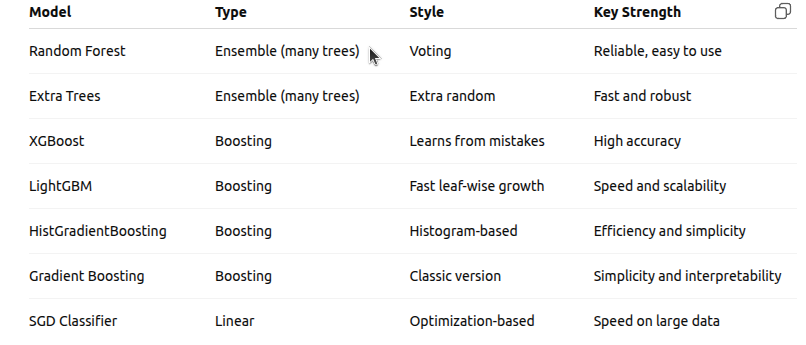